In [ ]:
import wandb

In [ ]:
wandb.login(key="9fd97502ce6cc4764d2b3cd65eaac39039c39083")

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embedding_dim, hidden_dim, num_layers, dropout, rnn_cell_type, device):
        super().__init__()
        cell = {"RNN": nn.RNN, "LSTM": nn.LSTM, "GRU": nn.GRU}[rnn_cell_type]
        self.device = device
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.cell = cell(embedding_dim, hidden_dim, num_layers=num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)

        self.embedding_weight_gradients = None
        self.embedding.weight.register_hook(self.save_embedding_gradients)

    def save_embedding_gradients(self, grad):
        self.embedding_weight_gradients = grad  # shape: (vocab_size, emb_dim)

    def forward(self, src):
        embedded = self.embedding(src)  # (batch, seq_len, emb_dim)
        outputs, hidden = self.cell(embedded)
        return outputs, hidden



class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (batch, hidden_dim)
        # encoder_outputs: (batch, seq_len, hidden_dim)
        # Expand decoder hidden state to match encoder_outputs shape
        decoder_hidden_expanded = decoder_hidden.unsqueeze(1).expand_as(encoder_outputs)
        # Calculate alignment scores
        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_expanded))  # (batch, seq_len, hidden)
        scores = self.v(energy).squeeze(2)  # (batch, seq_len)
        # Softmax to get attention weights
        attn_weights = F.softmax(scores, dim=1)  # (batch, seq_len)
        # Compute context vector
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch, hidden_dim)
        return context, attn_weights


class Decoder(nn.Module):
    def __init__(self, target_vocab_size, embedding_dim, hidden_dim, num_layers, dropout, rnn_cell_type, device):
        super().__init__()
        cell = {"RNN": nn.RNN, "LSTM": nn.LSTM, "GRU": nn.GRU}[rnn_cell_type]
        self.device = device
        self.embedding = nn.Embedding(target_vocab_size, embedding_dim)
        self.cell = cell(embedding_dim + hidden_dim, hidden_dim, num_layers=num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim * 2, target_vocab_size)  # hidden + context concatenated

    def forward(self, input_token, hidden, encoder_outputs):
        # input_token: (batch, 1)
        embedded = self.embedding(input_token)  # (batch, 1, emb_dim)
        # Get decoder hidden last layer's hidden state for attention query
        if isinstance(hidden, tuple):  # LSTM
            dec_hidden = hidden[0][-1]  # (batch, hidden_dim)
        else:
            dec_hidden = hidden[-1]     # (batch, hidden_dim)
        context, attn_weights = self.attention(dec_hidden, encoder_outputs)  # (batch, hidden_dim)
        # Concatenate embedded input and context vector along feature dim
        rnn_input = torch.cat([embedded, context.unsqueeze(1)], dim=2)  # (batch, 1, emb+hidden)
        output, hidden = self.cell(rnn_input, hidden)  # output: (batch, 1, hidden_dim)
        output = output.squeeze(1)  # (batch, hidden_dim)
        concat_output = torch.cat([output, context], dim=1)  # (batch, hidden_dim*2)
        logits = self.output_layer(concat_output)  # (batch, target_vocab_size)
        return logits, hidden, attn_weights


class SeqModel(nn.Module):
    def __init__(self, config, input_vocab_size, target_vocab_size):
        super().__init__()
        self.device = config["device"]
        self.tgt_vocab = config["target_vocab"]
        self.sos_token = self.tgt_vocab['<s>']
        self.eos_token = self.tgt_vocab['</s>']

        self.encoder = Encoder(
            input_vocab_size=input_vocab_size,
            embedding_dim=config["embedding_dim"],
            hidden_dim=config["hidden_dim"],
            num_layers=config["num_encoder_layers"],
            dropout=config["dropout"],
            rnn_cell_type=config["cell_type"],
            device=self.device,
        )
        self.decoder = Decoder(
            target_vocab_size=target_vocab_size,
            embedding_dim=config["embedding_dim"],
            hidden_dim=config["hidden_dim"],
            num_layers=config["num_decoder_layers"],
            dropout=config["dropout"],
            rnn_cell_type=config["cell_type"],
            device=self.device,
        )

    def forward(self, src, tgt, teacher_forcing_ratio=0.0):
        batch_size = src.size(0)
        max_len = tgt.size(1)
        vocab_size = self.decoder.output_layer.out_features

        encoder_outputs, hidden = self.encoder(src)
        input_token = tgt[:, 0].unsqueeze(1)  # <s>
        outputs = torch.zeros(batch_size, max_len, vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, max_len, encoder_outputs.size(1)).to(self.device)
        for t in range(max_len):
            logits, hidden, attn_weights = self.decoder(input_token, hidden, encoder_outputs)
            outputs[:, t, :] = logits
            attentions[:, t, :] = attn_weights.squeeze(1)
            top1 = logits.argmax(1).unsqueeze(1)
            input_token = tgt[:, t].unsqueeze(1) if torch.rand(1).item() < teacher_forcing_ratio else top1
        return outputs, attentions

    def greedy_decode(self, src_seq, max_len=30):
        self.eval()
        with torch.no_grad():
            src_seq = src_seq.unsqueeze(0).to(self.device)
            encoder_outputs, hidden = self.encoder(src_seq)
            input_token = torch.tensor([[self.sos_token]], device=self.device)
            decoded_tokens = [self.sos_token]
            for _ in range(max_len):
                logits, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
                next_token = logits.argmax(dim=1).item()
                decoded_tokens.append(next_token)
                if next_token == self.eos_token:
                    break
                input_token = torch.tensor([[next_token]], device=self.device)

            return decoded_tokens

    def beam_search_decode(self, src_seq, beam_width=5, max_len=30):
        self.eval()
        with torch.no_grad():
            src_seq = src_seq.unsqueeze(0).to(self.device)
            encoder_outputs, hidden = self.encoder(src_seq)
            sequences = [([self.sos_token], 0.0, hidden)]
            completed = []
            for _ in range(max_len):
                all_candidates = []
                for seq, score, hidden_state in sequences:
                    if seq[-1] == self.eos_token:
                        completed.append((seq, score))
                        continue
                    input_token = torch.tensor([[seq[-1]]], device=self.device)
                    logits, new_hidden, _ = self.decoder(input_token, hidden_state, encoder_outputs)
                    log_probs = F.log_softmax(logits, dim=1).squeeze(0)
                    topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)
                    for i in range(beam_width):
                        token = topk_indices[i].item()
                        token_score = topk_log_probs[i].item()
                        new_seq = seq + [token]
                        new_score = score + token_score
                        # Clone hidden
                        if isinstance(new_hidden, tuple):
                            hidden_clone = (new_hidden[0].clone(), new_hidden[1].clone())
                        else:
                            hidden_clone = new_hidden.clone()
                        all_candidates.append((new_seq, new_score, hidden_clone))
                if not all_candidates:
                    break
                sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
                if len(completed) >= beam_width:
                    break
            # If no sequences ended in <eos>, use the best current beam
            if not completed:
                completed = sequences
            completed = sorted(completed, key=lambda x: x[1], reverse=True)
            return completed[0][0]


    def greedy_decode_batch(self, src_batch, max_len=30):
        self.eval()
        batch_size = src_batch.size(0)
        src_batch = src_batch.to(self.device)

        with torch.no_grad():
            encoder_outputs, hidden = self.encoder(src_batch)
            input_token = torch.full((batch_size, 1), self.sos_token, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)
            decoded_tokens = torch.full((batch_size, max_len + 1), self.tgt_vocab['<pad>'], dtype=torch.long, device=self.device)
            decoded_tokens[:, 0] = self.sos_token

            for t in range(1, max_len + 1):
                logits, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
                next_token = logits.argmax(dim=1)
                decoded_tokens[:, t] = next_token
                finished = finished | (next_token == self.eos_token)
                if finished.all():
                    break
                input_token = next_token.unsqueeze(1)

        return decoded_tokens[:, 1:].tolist()
    
    def beam_search_decode_batch(self, src_batch, beam_width=5, max_len=30):
        self.eval()
        batch_size = src_batch.size(0)
        src_batch = src_batch.to(self.device)
        all_decoded = []
        with torch.no_grad():
            for i in range(batch_size):
                src_seq = src_batch[i].unsqueeze(0)  # (1, seq_len)
                encoder_outputs, hidden = self.encoder(src_seq)
                sequences = [([self.sos_token], 0.0, hidden)]
                completed = []
                for _ in range(max_len):
                    all_candidates = []
                    for seq, score, hidden_state in sequences:
                        if seq[-1] == self.eos_token:
                            completed.append((seq, score))
                            continue
                        input_token = torch.tensor([[seq[-1]]], device=self.device)
                        logits, new_hidden, _ = self.decoder(input_token, hidden_state, encoder_outputs)
                        log_probs = F.log_softmax(logits, dim=1).squeeze(0)
                        topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)
                        for k in range(beam_width):
                            token = topk_indices[k].item()
                            token_score = topk_log_probs[k].item()
                            new_seq = seq + [token]
                            new_score = score + token_score
                            if isinstance(new_hidden, tuple):  # LSTM
                                hidden_clone = (new_hidden[0].clone(), new_hidden[1].clone())
                            else:
                                hidden_clone = new_hidden.clone()

                            all_candidates.append((new_seq, new_score, hidden_clone))
                    sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
                    if len(completed) >= beam_width:
                        break
                completed += [b for b in sequences if b[0][-1] == self.eos_token]
                completed = sorted(completed, key=lambda x: x[1], reverse=True)
                best_seq = completed[0][0]
                all_decoded.append(best_seq)
        return all_decoded

In [2]:
SPECIAL_TOKENS = {'<unk>': 0, '<s>': 1, '</s>': 2, '<pad>': 3}

def build_vocab(data, is_input=True):
    vocab = {token: idx for idx, token in enumerate(SPECIAL_TOKENS)}
    idx = len(vocab)
    for word in data:
        chars = list(word.strip())
        for ch in chars:
            if ch not in vocab:
                vocab[ch] = idx
                idx += 1
    return vocab

In [3]:
import pandas as pd
import random


def load_data(path):
    df = pd.read_csv(path, sep='\t', names=['target', 'input', 'attest'])
    df = df.dropna()
    df = df[df['input'].str.strip() != '</s> </s']
    return df['input'].tolist(), df['target'].tolist(), df['attest'].astype(int).tolist()

def encode_sequence(seq, vocab, add_start=False, add_end=False):
    tokens = []
    if add_start:
        tokens.append(vocab['<s>'])
    tokens += [vocab.get(ch, vocab['<unk>']) for ch in seq]
    if add_end:
        tokens.append(vocab['</s>'])
    return tokens

def decode_sequence(indices, inv_vocab):
    return "".join([inv_vocab.get(idx, "") for idx in indices])

def prepare_data(path, input_vocab=None, target_vocab=None):
    inputs, targets, attests = load_data(path)
    if input_vocab is None:
        input_vocab = build_vocab(inputs)
    if target_vocab is None:
        target_vocab = build_vocab(targets)
    encoded = []
    for inp, tgt, att in zip(inputs, targets, attests):
        src = encode_sequence(inp, input_vocab)
        tgt_in = encode_sequence(tgt, target_vocab, add_start=True)
        tgt_out = encode_sequence(tgt, target_vocab, add_end=True)
        encoded.append((src, tgt_in, tgt_out, att))
    return encoded, input_vocab, target_vocab

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

class DakshinaDataset(Dataset):
    def __init__(self, encoded_data):
        self.data = encoded_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    pad_idx = SPECIAL_TOKENS['<pad>']
    src_seqs = [torch.tensor(x[0], dtype=torch.long) for x in batch]
    tgt_in_seqs = [torch.tensor(x[1], dtype=torch.long) for x in batch]
    tgt_out_seqs = [torch.tensor(x[2], dtype=torch.long) for x in batch]
    src_padded = pad_sequence(src_seqs, batch_first=True, padding_value=pad_idx)
    tgt_in_padded = pad_sequence(tgt_in_seqs, batch_first=True, padding_value=pad_idx)
    tgt_out_padded = pad_sequence(tgt_out_seqs, batch_first=True, padding_value=pad_idx)
    return src_padded, tgt_in_padded, tgt_out_padded


def get_dataloader(path, batch_size=32, input_vocab=None, target_vocab=None, shuffle=True, resample=True):
    encoded_data, input_vocab, target_vocab = prepare_data(path, input_vocab, target_vocab)
    dataset = DakshinaDataset(encoded_data)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    if resample:
        # Extract attestation column and apply smoothing
        alpha = 1.0
        attests = [x[3] for x in encoded_data]
        weights = [att ** alpha for att in attests]
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
        dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, collate_fn=collate_fn)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

    return dataloader, input_vocab, target_vocab


In [5]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pickle
font_path = "/kaggle/input/fonts-extra/NotoSansDevanagari-Regular.ttf"
prop = fm.FontProperties(fname=font_path)

class Evaluator:
    def __init__(self, model, src_vocab, tgt_vocab, device):
        self.model = model
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.device = device
        self.idx2src = {idx: char for char, idx in src_vocab.items()}
        self.idx2tgt = {idx: char for char, idx in tgt_vocab.items()}

    def greedy_decode_attention(self, src_tensor, max_len=30):
        """Greedy decode with attention weights extraction."""
        self.model.eval()
        src_tensor = src_tensor.unsqueeze(0).to(self.device)  # (1, seq_len)
        encoder_outputs, hidden = self.model.encoder(src_tensor)
        input_token = torch.tensor([[self.tgt_vocab['<s>']]], device=self.device)
        decoded_indices = []
        attentions = []
        for _ in range(max_len):
            logits, hidden, attn_weights = self.model.decoder(input_token, hidden, encoder_outputs)
            attentions.append(attn_weights.squeeze(0).cpu())  # (src_seq_len,)
            top1 = logits.argmax(1)
            token = top1.item()
            if token == self.tgt_vocab['</s>']:
                break
            decoded_indices.append(token)
            input_token = top1.unsqueeze(1)
        attentions = torch.stack(attentions)  # (tgt_len, src_len)
        return decoded_indices, attentions

    def beam_search_decode_attention(self, src_tensor, beam_width=5, max_len=30):
        self.model.eval()
        src_tensor = src_tensor.unsqueeze(0).to(self.device)
        encoder_outputs, hidden = self.model.encoder(src_tensor)
        # Each candidate: (sequence, score, hidden_state, attentions)
        sequences = [([self.tgt_vocab['<s>']], 0.0, hidden, [])]
        completed = []
        for _ in range(max_len):
            all_candidates = []
            for seq, score, hidden_state, attns in sequences:
                if seq[-1] == self.tgt_vocab['</s>']:
                    completed.append((seq, score, attns))
                    continue 
                input_token = torch.tensor([[seq[-1]]], device=self.device)
                logits, new_hidden, attn_weights = self.model.decoder(input_token, hidden_state, encoder_outputs)
                log_probs = F.log_softmax(logits, dim=1).squeeze(0)
                topk_log_probs, topk_indices = torch.topk(log_probs, beam_width) 
                for k in range(beam_width):
                    token = topk_indices[k].item()
                    token_score = topk_log_probs[k].item()
                    new_seq = seq + [token]
                    new_score = score + token_score
                    new_attns = attns + [attn_weights.squeeze(0).cpu()]  # Append current step attention
                    if isinstance(new_hidden, tuple):
                        hidden_clone = (new_hidden[0].clone(), new_hidden[1].clone())
                    else:
                        hidden_clone = new_hidden.clone() 
                    all_candidates.append((new_seq, new_score, hidden_clone, new_attns))
            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
            if len(completed) >= beam_width:
                break
        completed += [(seq, score, attns) for seq, score, _, attns in sequences if seq[-1] == self.tgt_vocab['</s>']]
        completed = sorted(completed, key=lambda x: x[1], reverse=True)
        if len(completed) == 0:
            # Fall back to top beam candidate if none completed
            top_seq, top_score, _, top_attns = sequences[0]
            completed = [(top_seq, top_score, top_attns)]
        else:
            # Otherwise ensure only (seq, score, attns) in completed
            pass
        best_seq, _, best_attns = completed[0]
        best_seq = best_seq[1:]  # remove <s>
        if self.tgt_vocab['</s>'] in best_seq:
            best_seq = best_seq[:best_seq.index(self.tgt_vocab['</s>'])]
        attentions = torch.stack(best_attns)  # (tgt_len, src_len)
        return best_seq, attentions

    def greedy_decode_vanilla(self, src_tensor, max_len=30):
        self.model.eval()
        src_tensor = src_tensor.unsqueeze(0).to(self.device)  # (1, seq_len)
        encoder_outputs, hidden = self.model.encoder(src_tensor)
        input_token = torch.tensor([[self.tgt_vocab['<s>']]], device=self.device)
        decoded_indices = []
        for _ in range(max_len):
            logits, hidden = self.model.decoder(input_token, hidden)
            top1 = logits.argmax(1)
            token = top1.item()
            if token == self.tgt_vocab['</s>']:
                break
            decoded_indices.append(token)
            input_token = top1.unsqueeze(1)
        return decoded_indices

    def beam_search_decode_vanilla(self, src_tensor, beam_width=5, max_len=30):
        self.model.eval()
        src_tensor = src_tensor.unsqueeze(0).to(self.device)
        encoder_outputs, hidden = self.model.encoder(src_tensor)
        sequences = [([self.tgt_vocab['<s>']], 0.0, hidden)]
        completed = []
        for _ in range(max_len):
            all_candidates = []
            for seq, score, hidden_state in sequences:
                if seq[-1] == self.tgt_vocab['</s>']:
                    completed.append((seq, score))
                    continue   
                input_token = torch.tensor([[seq[-1]]], device=self.device)
                logits, new_hidden = self.model.decoder(input_token, hidden_state)
                log_probs = F.log_softmax(logits, dim=1).squeeze(0)
                topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)
                for k in range(beam_width):
                    token = topk_indices[k].item()
                    token_score = topk_log_probs[k].item()
                    new_seq = seq + [token]
                    new_score = score + token_score
                    
                    if isinstance(new_hidden, tuple):
                        hidden_clone = (new_hidden[0].clone(), new_hidden[1].clone())
                    else:
                        hidden_clone = new_hidden.clone()
                    all_candidates.append((new_seq, new_score, hidden_clone))
            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
            if len(completed) >= beam_width:
                break
        completed += [b for b in sequences if b[0][-1] == self.tgt_vocab['</s>']]
        completed = sorted(completed, key=lambda x: x[1], reverse=True)
        best_seq = completed[0][0]
        best_seq = best_seq[1:]  # remove <s>
        if self.tgt_vocab['</s>'] in best_seq:
            best_seq = best_seq[:best_seq.index(self.tgt_vocab['</s>'])]
        return best_seq

    def evaluate_accuracy_vanilla(self, data_loader, use_beam=False, beam_width=5, csv_path="transliteration_results_van.csv"):
        """Evaluate transliteration accuracy and save results to CSV."""
        self.model.eval()
        correct = 0
        corrects = 0
        total = 0
        # Open CSV file to store results
        with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Input (Roman)', 'Predicted (Devanagari)', 'True (Devanagari)', 'Match'])

            for batch in data_loader:
                src_batch, _, tgt_batch = batch
                src_batch = src_batch.to(self.device)
                tgt_batch = tgt_batch.to(self.device)

                for src_tensor, tgt_tensor in zip(src_batch, tgt_batch):
                    # --- Decode ground truth ---
                    tgt_tokens = tgt_tensor.tolist()
                    tgt_tokens = [t for t in tgt_tokens if t != self.tgt_vocab['<pad>']]
                    if self.tgt_vocab['<s>'] in tgt_tokens:
                        tgt_tokens = tgt_tokens[1:]
                    if self.tgt_vocab['</s>'] in tgt_tokens:
                        tgt_tokens = tgt_tokens[:tgt_tokens.index(self.tgt_vocab['</s>'])]

                    true_str = ''.join([self.idx2tgt.get(t, '') for t in tgt_tokens])

                    # --- Decode prediction ---
                    if use_beam:
                        pred_tokens = self.beam_search_decode_vanilla(src_tensor, beam_width=beam_width)
                    else:
                        pred_tokens = self.greedy_decode_vanilla(src_tensor)

                    pred_str = ''.join([self.idx2tgt.get(t, '') for t in pred_tokens])

                    # --- Decode input (Romanized) ---
                    src_tokens = src_tensor.tolist()
                    src_tokens = [t for t in src_tokens if t != self.src_vocab['<pad>']]
                    input_str = ''.join([self.idx2src.get(t, '') for t in src_tokens])

                    # --- Compare both token-wise and string-wise ---
                    if pred_tokens == tgt_tokens:
                        correct += 1
                    if pred_str == true_str:
                        corrects += 1

                    total += 1

                    # Write row to CSV
                    writer.writerow([input_str, pred_str, true_str, pred_str == true_str])

        accuracy = correct / total
        print(f"Token Accuracy: {accuracy * 100:.2f}%")
        print(f"String Accuracy: {corrects / total:.4f} ({corrects}/{total})")
        print(f"CSV results saved to: {csv_path}")
        return accuracy

    def evaluate_accuracy_attention(self, data_loader, use_beam=False, beam_width=5,
                                     csv_path="transliteration_results.csv",
                                     attention_dump_path="correct_attention_weights.pkl"):
        self.model.eval()
        correct = 0
        corrects = 0
        total = 0
        saved_attentions = []
        with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Input (Roman)', 'Predicted (Devanagari)', 'True (Devanagari)', 'Match'])
    
            for batch in data_loader:
                src_batch, _, tgt_batch = batch
                src_batch = src_batch.to(self.device)
                tgt_batch = tgt_batch.to(self.device)
    
                for src_tensor, tgt_tensor in zip(src_batch, tgt_batch):
                    # Prepare ground truth
                    tgt_tokens = tgt_tensor.tolist()
                    tgt_tokens = [t for t in tgt_tokens if t != self.tgt_vocab['<pad>']]
                    if self.tgt_vocab['<s>'] in tgt_tokens:
                        tgt_tokens = tgt_tokens[1:]
                    if self.tgt_vocab['</s>'] in tgt_tokens:
                        tgt_tokens = tgt_tokens[:tgt_tokens.index(self.tgt_vocab['</s>'])]
    
                    true_str = ''.join([self.idx2tgt.get(t, '') for t in tgt_tokens])
    
                    # Decode prediction and get attention
                    if use_beam:
                        pred_tokens, attn_weights = self.beam_search_decode_attention(src_tensor, beam_width=beam_width)
                    else:
                        pred_tokens, attn_weights = self.greedy_decode_attention(src_tensor)
    
                    pred_str = ''.join([self.idx2tgt.get(t, '') for t in pred_tokens])
    
                    # Prepare input string
                    src_tokens = src_tensor.tolist()
                    src_tokens = [t for t in src_tokens if t != self.src_vocab['<pad>']]
                    input_str = ''.join([self.idx2src.get(t, '') for t in src_tokens])
    
                    # Accuracy check
                    if pred_tokens == tgt_tokens:
                        correct += 1
                    if pred_str == true_str:
                        corrects += 1
    
                        # Save attention weights for correct predictions
                        saved_attentions.append({
                            "input_str": input_str,
                            "pred_str": pred_str,
                            "true_str": true_str,
                            "attn_weights": attn_weights.detach().cpu().numpy() if hasattr(attn_weights, "cpu") else attn_weights
                        })
    
                    total += 1
                    writer.writerow([input_str, pred_str, true_str, pred_str == true_str])
    
        accuracy = correct / total
        print(f"Token Accuracy: {accuracy * 100:.2f}%")
        print(f"String Accuracy: {corrects / total:.4f} ({corrects}/{total})")
        print(f"CSV results saved to: {csv_path}")
        # Dump attention weights
        with open(attention_dump_path, "wb") as f:
            pickle.dump(saved_attentions, f)
        print(f"Saved attention weights to {attention_dump_path}")
        return accuracy


    def plot_attention_heatmaps(self, file_path, max_samples=9):
        """Plot and log attention heatmaps for up to max_samples inputs in a 3x3 grid."""
        data = pickle.load(open('correct_attention_weights.pkl', 'rb'))
        n = max_samples
        data = random.sample(data, 3 * n)
        random.shuffle(data)
        fig, axes = plt.subplots(3, 3, figsize=(12, 12), constrained_layout=True)
        axes = axes.flatten()
        for i in range(n):
            pred_str = data[i]['pred_str']
            src_str = data[i]['input_str']
            pred_chars = list(pred_str)
            pred_chars.append("</s>")
            src_chars = list(src_str)
            attn = data[i]['attn_weights']
            attn = attn[:len(pred_chars), :len(src_chars)]
            im = axes[i].imshow(attn, cmap='viridis', aspect='auto')
            axes[i].set_title(f"Input: {src_str}")
            axes[i].set_xlabel("Source Tokens")
            axes[i].set_ylabel("Target Tokens")
            axes[i].set_yticks(range(len(pred_chars)))
            axes[i].set_yticklabels(pred_chars, fontproperties=prop)
            axes[i].set_xticks(range(len(src_chars)))
            axes[i].set_xticklabels(src_chars)
        for j in range(n, 9):
            axes[j].axis('off')
        # plt.tight_layout()
        cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
        cbar.ax.tick_params(labelsize=8)
        plt.savefig("attn_maps.png", bbox_inches='tight', dpi=300)
        plt.show()

In [6]:
import numpy as np
import random
import csv

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, input_vocab, target_vocab = get_dataloader("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv", batch_size=256, shuffle=True, resample=False)
test_loader, _, _ = get_dataloader("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv", batch_size=256, input_vocab=input_vocab, target_vocab=target_vocab, shuffle=False, resample=False)
val_loader, _, _ = get_dataloader("/kaggle/working/filtered_output.tsv", batch_size=256, input_vocab=input_vocab, target_vocab=target_vocab, shuffle=False, resample=False)
run_name = (
        f"ED{256}_"
        f"HD{256}_"
        f"CT{'LSTM'}_"
        f"NE{2}_"
        f"ND{2}_"
        f"DO{0.25}_LR{0.001}_"
        f"BW{3}"
)
# wandb.run.name = run_name
config = {
    'input_vocab_size': len(input_vocab),
    'target_vocab_size': len(target_vocab),
    'target_vocab': target_vocab,
    'input_vocab': input_vocab,
    'embedding_dim': 256,
    'hidden_dim': 256,
    'num_encoder_layers': 2,
    'num_decoder_layers': 2,
    'cell_type': 'LSTM',
    'dropout': 0.25,
    'pad_idx': SPECIAL_TOKENS['<pad>'],
    'lr': 0.001,
    'device': device,
    'model_name': run_name
}
src_batch, _, tgt_batch = next(iter(val_loader))
model = SeqModel(config, len(input_vocab), len(target_vocab))
model.load_state_dict(torch.load(f"/kaggle/input/models/ED256_HD256_CTLSTM_NE2_ND2_DO0.25_LR0.001_BW3.pt", map_location=config['device']))
model.to(config['device'])
evaluator = Evaluator(model, input_vocab, target_vocab, device=device)
# evaluator = Evaluator(model, input_vocab, target_vocab, device)
evaluator.evaluate_accuracy_attention(test_loader, use_beam=True, beam_width=3)
evaluator.plot_attention_heatmaps("./correct_attention_weights.pkl")

SeqModel(
  (encoder): Encoder(
    (embedding): Embedding(30, 256)
    (cell): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.25)
  )
  (decoder): Decoder(
    (embedding): Embedding(67, 256)
    (cell): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.25)
    (attention): Attention(
      (W1): Linear(in_features=256, out_features=256, bias=True)
      (W2): Linear(in_features=256, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (output_layer): Linear(in_features=512, out_features=67, bias=True)
  )
)

In [10]:
def compute_connectivity_matrix(model, src_tensor, tgt_tensor, tgt_vocab, device):
    model.eval()
    model.zero_grad()

    input_len = src_tensor.size(1)
    output_len = tgt_tensor.size(1)

    # Run forward normally (no need for return_embeddings)
    encoder_outputs, hidden = model.encoder(src_tensor)

    connectivity = torch.zeros((output_len, input_len)).to(device)

    input_token = tgt_tensor[:, 0].unsqueeze(1)
    for t in range(output_len):
        logits, hidden, _ = model.decoder(input_token, hidden, encoder_outputs)

        target_index = tgt_tensor[:, t]  # (batch=1,)
        # Pick the logit of the target token (batch=1, scalar)
        logit = logits[0, target_index]

        model.zero_grad()
        logit.backward(retain_graph=True)

        # Get embedding weight grads: shape (vocab_size, emb_dim)
        embedding_grads = model.encoder.embedding_weight_gradients  # hooked grads

        # Gather gradients for the input tokens:
        input_tokens = src_tensor[0]  # shape: (input_len,)
        grads_for_tokens = embedding_grads[input_tokens]  # (input_len, emb_dim)

        grad_norms = grads_for_tokens.norm(p=2, dim=1)  # (input_len,)

        connectivity[t] = grad_norms

        input_token = tgt_tensor[:, t].unsqueeze(1)

    return connectivity.detach().cpu().numpy()

In [11]:
# Example input
seed_everything(100)
train_loader, input_vocab, target_vocab = get_dataloader("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv", batch_size=256, shuffle=True, resample=False)
input_str = "sapramaan"
output_str = "सप्रमान"
model = SeqModel(config, len(input_vocab), len(target_vocab))
model.load_state_dict(torch.load(f"/kaggle/input/models/ED256_HD256_CTLSTM_NE2_ND2_DO0.25_LR0.001_BW3.pt", map_location=config['device']))
model.to(config['device'])
input_tensor = torch.tensor([input_vocab[c] for c in list(data[-2]['input_str'])]).unsqueeze(0).to(device) 
target_tensor = torch.tensor([target_vocab[c] for c in list(data[-2]['pred_str'])+["</s>"]]).unsqueeze(0).to(device) 

connectivity_matrix = compute_connectivity_matrix(model, input_tensor, target_tensor, target_vocab, device)


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_connectivity_heatmap(connectivity, input_tokens, output_tokens, output_path):
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(
            connectivity,
            annot=False,
            cmap="viridis",
            cbar=False,
            linewidths=0.2,
            linecolor='white',
            vmin=0,
            vmax=np.max(connectivity),
            square=False,
        )

    # Annotate each cell
    for i in range(connectivity.shape[0]):  # output tokens
        for j in range(connectivity.shape[1]):  # input tokens
            text = f"{input_tokens[j]}\n{connectivity[i, j]:.2f}"
            ax.text(j + 0.5, i + 0.5, text,
                    ha='center', va='center', fontsize=14,
                    color='white' if connectivity[i, j] < 0.35 else 'black',
                    fontproperties=prop)

    # Bottom x-axis (input tokens)
    ax.set_xticks(np.arange(len(input_tokens)) + 0.5)
    ax.set_xticklabels(input_tokens, fontsize=16)
    
    # Left y-axis (output tokens)
    ax.set_yticks(np.arange(len(output_tokens)) + 0.5)
    ax.set_yticklabels(output_tokens, fontsize=20, fontproperties=prop, rotation=0)
    ax.tick_params(axis='y', labelsize=16)
    
    ax.set_xlabel("Input English Tokens", fontsize=14)
    ax.set_ylabel("Output Hindi Tokens", fontsize=14)

    plt.title("Input-Output Connectivity with Embedded Tokens", fontsize=16)
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()



# plot_connectivity_heatmap(connectivity_matrix, list(data[-2]['input_str']), list(data[-2]['pred_str'])+["</s>"])

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def draw_token_alignment_diagram(input_tokens, output_tokens, connectivity_matrix, output_path):
    fig, ax = plt.subplots(figsize=(len(input_tokens) * 1.2 + 4, len(output_tokens) * 1.8))
    ax.axis('off')

    box_size = 1
    padding = 0.1
    max_weight = np.max(connectivity_matrix)

    for i, output_token in enumerate(output_tokens):
        y = -i * (box_size + 1)

        for j, input_token in enumerate(input_tokens):
            x = j * (box_size + padding)
            weight = connectivity_matrix[i, j]
            alpha = weight / max_weight if max_weight > 0 else 0

            rect = Rectangle(
                (x, y), box_size, box_size,
                linewidth=1, edgecolor='black',
                facecolor = (255/255, 165/255, 0/255, alpha)  # RGB for green + dynamic alpha
            )
            ax.add_patch(rect)

            ax.text(x + box_size/2, y + box_size/2, input_token,
                    ha='center', va='center', fontsize=16)

        # Arrow and output character
        arrow_x = len(input_tokens) * (box_size + padding) + 0.5
        ax.text(arrow_x, y + box_size/2, "→", fontsize=18, va='center')
        ax.text(arrow_x + 1, y + box_size/2, output_token,
                fontsize=24, fontweight='bold', va='center', fontproperties=prop)

    ax.set_xlim(-1, arrow_x + 3)
    ax.set_ylim(-len(output_tokens) * (box_size + 1), 1)
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()

# draw_token_alignment_diagram(
#     input_tokens=list(data[-2]['input_str']),
#     output_tokens=list(data[-2]['pred_str']) + ["</s>"],
#     connectivity_matrix=connectivity_matrix
# )


In [39]:
# Example input
seed_everything(100)
train_loader, input_vocab, target_vocab = get_dataloader("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv", batch_size=256, shuffle=True, resample=False)
input_str = "sapramaan"
output_str = "सप्रमान"
model = SeqModel(config, len(input_vocab), len(target_vocab))
model.load_state_dict(torch.load(f"/kaggle/input/models/ED256_HD256_CTLSTM_NE2_ND2_DO0.25_LR0.001_BW3.pt", map_location=config['device']))
model.to(config['device'])
input_tensor = torch.tensor([input_vocab[c] for c in list(data[7]['input_str'])]).unsqueeze(0).to(device) 
target_tensor = torch.tensor([target_vocab[c] for c in list(data[7]['pred_str'])+["</s>"]]).unsqueeze(0).to(device) 

connectivity_matrix = compute_connectivity_matrix(model, input_tensor, target_tensor, target_vocab, device)


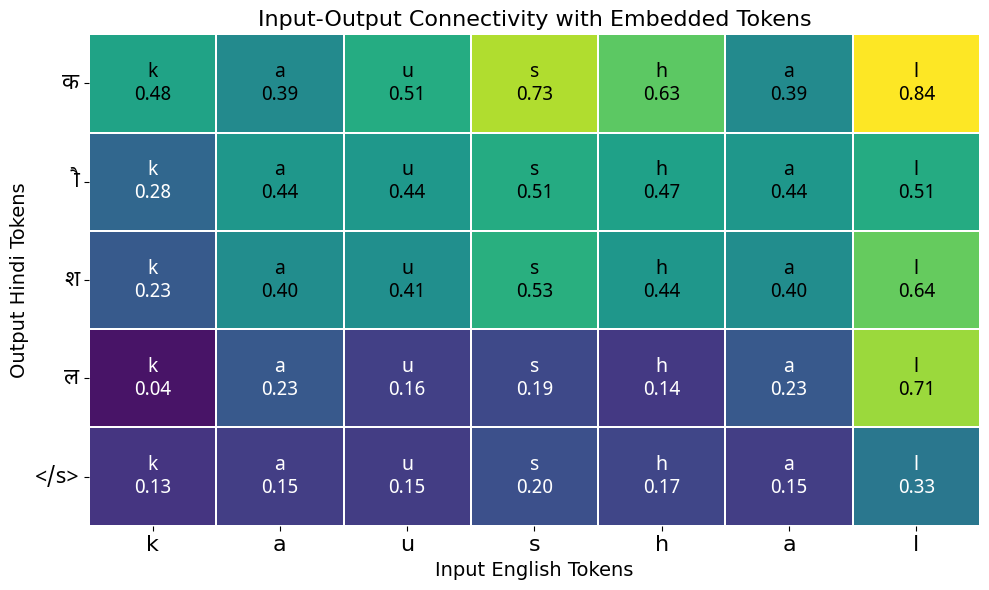

In [40]:
output_path=f"{data[7]['input_str']}_heat.png"
plot_connectivity_heatmap(connectivity_matrix, list(data[7]['input_str']), list(data[7]['pred_str'])+["</s>"], output_path)

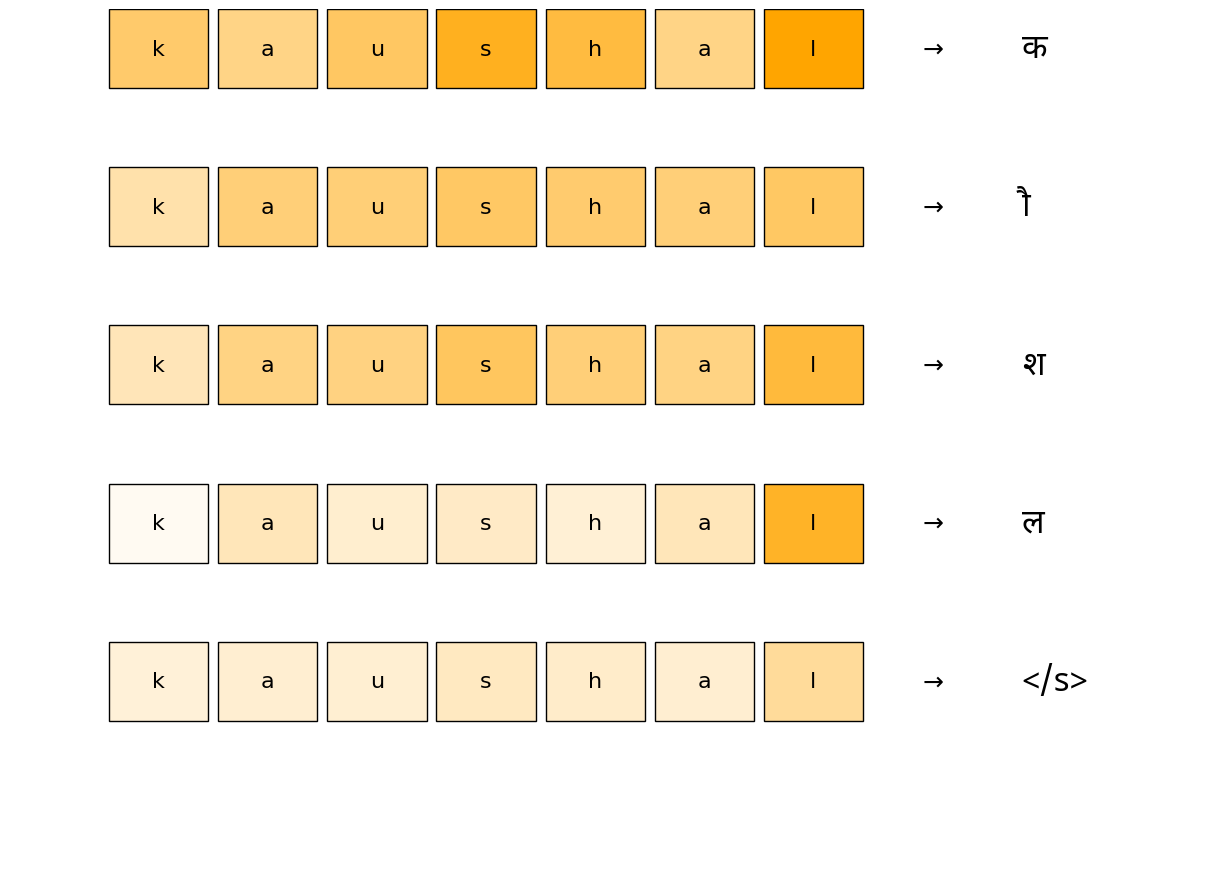

In [41]:
output_path=f"{data[7]['input_str']}_align.png"
draw_token_alignment_diagram(
    input_tokens=list(data[7]['input_str']),
    output_tokens=list(data[7]['pred_str']) + ["</s>"],
    connectivity_matrix=connectivity_matrix,
    output_path=output_path
)